<a href="https://colab.research.google.com/github/dkioroglou/programmers_salaries_2023/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/dkioroglou/programmers_salaries_2023/main/data/salaries_2023.csv")

In [11]:
df = df[[
      '[Fixed] Ποιος είναι ο ΕΤΗΣΙΟΣ ΚΑΘΑΡΟΣ μισθός σου σε €;',
      'Με ποιες γλώσσες προγραμματισμού δουλεύεις επαγγελματικά αυτή την περίοδο;',
      'Πόσα χρόνια δουλεύεις επαγγελματικά ως προγραμματιστής;',
      'Φύλλο;',
      '[GROUP] Σε ποια πόλη δουλεύεις, Greece ή Abroad',
      'Τι μέγεθος είναι η εταιρεία που δουλεύεις;'
      ]]

df.columns = [
      'salary',
      'languages',
      'experience',
      'gender',
      'jobLocation',
      'companySize'
      ]

# Missing values distribution

In [12]:
df.isna().sum()

salary         0
languages      0
experience     0
gender         2
jobLocation    0
companySize    0
dtype: int64

In [13]:
df['gender'].value_counts()

Άντρας               949
Γυναίκα               53
Προτιμώ να μην πω      1
Nuclear Sub            1
Name: gender, dtype: int64

In [14]:
mask = df.isna()['gender']
df[mask]

,salary,languages,experience,gender,jobLocation,companySize
64,19600.0,"JavaScript, Ruby",7,NaN,Ελλάδα,201 - 500
541,10100.0,"Java, JavaScript",1,NaN,Ελλάδα,101 - 200


In [15]:
# Remove entries with missing or unspecified gender
df =  df.drop([64, 541, 68, 167])

# Distribution of salaries

In [16]:
df['salary'].describe()

count      1002.000000
mean      24117.334262
std       16305.507428
min          15.008000
25%       14820.000000
50%       20155.000000
75%       27595.000000
max      180000.000000
Name: salary, dtype: float64

<Axes: xlabel='salary', ylabel='Count'>

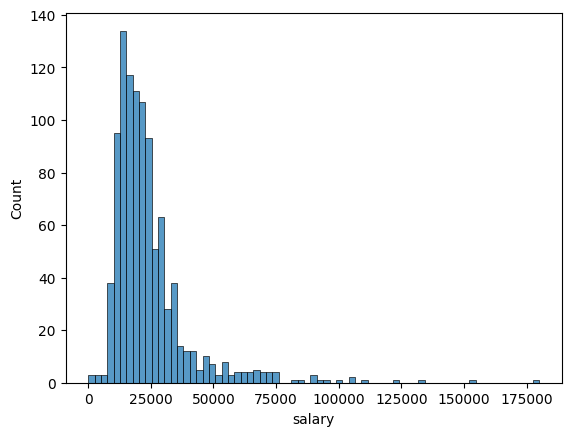

In [17]:
sns.histplot(df['salary'])

In [18]:
# Remove outliers
# Select data with salaries between the 10th and 90th percentiles of salaries
perc10th =  df['salary'].quantile(0.1)
perc90th = df['salary'].quantile(0.9)
df = df.query('salary >= @perc10th & salary <= @perc90th')

<Axes: xlabel='salary', ylabel='Count'>

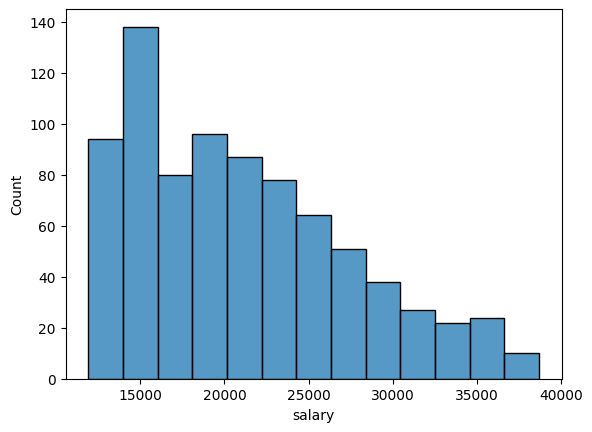

In [19]:
sns.histplot(df['salary'])

# Sample size after filtering

In [20]:
df.shape

(809, 6)

# Gender distribution after filtering

In [21]:
df['gender'].value_counts()

Άντρας     768
Γυναίκα     41
Name: gender, dtype: int64

## Feature engineering and recoding

In [22]:
df['languagesNumber'] = df['languages'].map(lambda x: len(x.split(",")) if ',' in x else 1)

In [23]:
df['languagesNumber'].value_counts()

1    435
2    263
3     83
4     18
5      7
6      3
Name: languagesNumber, dtype: int64

In [24]:
df['companySize'].value_counts()

501+         256
11 - 50      179
201 - 500    106
51 - 100      94
101 - 200     92
1 - 10        82
Name: companySize, dtype: int64

In [25]:
df['companySizeBinned'] = df['companySize'].map({
                                                '1 - 10':'small',
                                                '11 - 50': 'small',
                                                '51 - 100': 'small',
                                                '101 - 200': 'medium',
                                                '201 - 500': 'medium',
                                                '501+': 'large'
                                                })

In [26]:
df['companySizeBinned'].value_counts()

small     355
large     256
medium    198
Name: companySizeBinned, dtype: int64

In [27]:
df['companySizeBinnedRecoded'] = df['companySizeBinned'].map({"small":1, "medium":2, "large": 3})

In [28]:
df['genderRecoded'] = df['gender'].map({"Άντρας":1, "Γυναίκα":0})

In [29]:
df['jobLocationRecoded'] = df['jobLocation'].map({"Ελλάδα":1, "Εξωτερικό":0})

# Ordinary Least Square regression

In [31]:
X = df[['genderRecoded', 'experience', 'languagesNumber', 'companySizeBinnedRecoded', 'jobLocationRecoded']]
X.insert(0, 'intercept', 1)
y = df['salary']

In [32]:
model = sm.OLS(y, X).fit()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     76.04
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           2.85e-65
Time:                        13:43:02   Log-Likelihood:                -8095.5
No. Observations:                 809   AIC:                         1.620e+04
Df Residuals:                     803   BIC:                         1.623e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                 2.264e+04   1245.599     18.176      0.000    2.02e+04    2.51e+04
genderRecoded              712.8264    865.005      0.824      0.410    -985.112    2410.764
experience                 717.7014     45.529     15.764      0.000     628.332     807.070
languagesNumber            -73.7877    223.683     -0.330      0.742    -512.860     365.285
companySizeBinnedRecoded  1037.6986    220.377      4.709      0.000     605.115    1470.282
jobLocationRecoded       -7683.0672    713.801    -10.764      0.000   -9084.204   -6281.931
==============================================================================
Omnibus:                       25.372   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.106
Skew:                          -0.020   Prob(JB):                     8.88e-14
Kurtosis:                       4.335   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

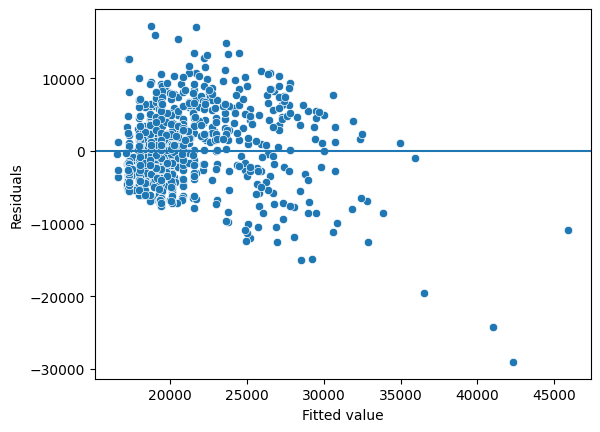

In [34]:
# Plot residuals
sns.scatterplot(
    x=model.get_prediction().summary_frame()['mean'],
    y=model.resid
    )
plt.axhline(y=0)
plt.xlabel("Fitted value")
plt.ylabel("Residuals")
plt.show()

# Results interpretation

In [80]:
model.params

intercept                   22640.493550
genderRecoded                 712.826352
experience                    717.701417
languagesNumber               -73.787692
companySizeBinnedRecoded     1037.698576
jobLocationRecoded          -7683.067187
dtype: float64

## General remark

Based on the included features, the model captures only 32% of the variability of the observed salaries. That's not great, but at least it represents a decent starting point.

The coefficients for the factors "gender" and "number of languages" were statistically not significant. This means that these factors do not appear to have an effect on the observed salaries. However, this result could also be due to the sample size.

## Interpretation

If the programmer works in Greece, then the annual income (ie without considering any the other factor) is 14957 €, whereas abroad is 30323 €.

Then, we consider each factor one by one, keeping at the same time the rest fixed:
1. If the programmer is male then 712 € are added to his annual income.
2. For every year of experience the programmer has, 717 € are added to the annual income.
3. If the programmer works for a medium-sized company (101 to 500 people) then 1037 € are added to his annual incone, whereas 2074 € are added If he works for a large company (501+ poeple).
2. Now, something unexpected. For every additional language the programmer knows, his annual income is reduced by 73 €. However, keep in mind that all the values I'm referring to, have a range and I'm considering the mean. This factor has a mean of 73 € and a range that goes from -512 € to 365 €. This means that there are programmers that for each language they know, their annual income is reduced by 512 € and others that their annual income is increased by 365 €. However, on average the annual income is reduced by 73 € for every additional language the programmer knows.

Therefore, if we consider a programmer with the following characteristics:
- The programmer is male.
- His job is in Greece.
- He works for a medium-sized company.
- He has 2 yeas of experience.
- He knows 2 programming languages.

then his annual income could range from 24270 to 27087 € with a mean of 25678 €. Under certain conditions (not captured by the model) his annual income can range from 15012 to 36344 €.

